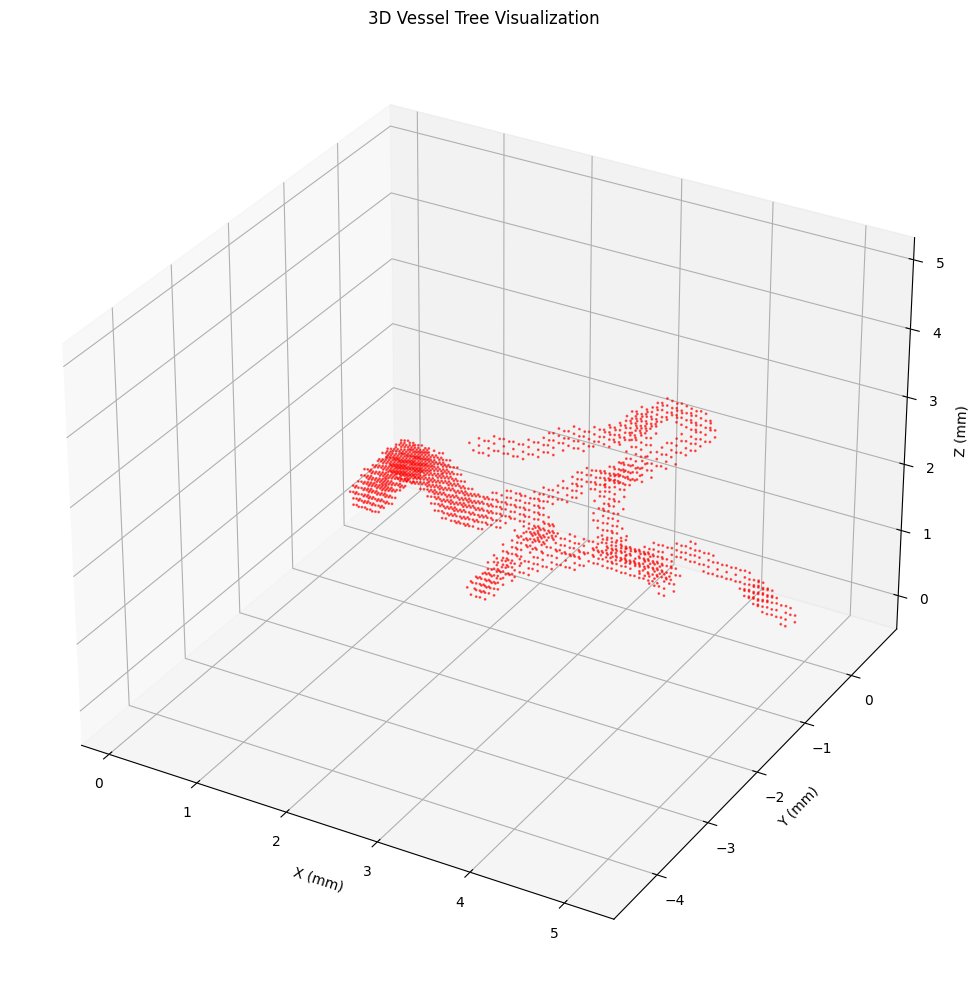


Vessel Statistics:
  Voxels: 1836
  Volume: 1.84 mm³
  Bounding box: (59, 45, 54)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nib
from typing import Callable, Optional

def rotate_vector(v, axis, angle):
    """Rotate vector v around axis by angle (radians) using Rodrigues' formula."""
    axis = axis / np.linalg.norm(axis)
    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])
    R = np.eye(3) + np.sin(angle)*K + (1 - np.cos(angle))*(K @ K)
    return R @ v


def generate_tortuous_segment(start_point, direction, length, n_points, tortuosity_dist):
    """
    Generate a tortuous 3D segment by subdividing into small steps with random deviation.
    Returns list of points [(x0,y0,z0), ..., (xn,yn,zn)].
    """
    points = [np.array(start_point, dtype=float)]
    current_dir = np.array(direction, dtype=float) / np.linalg.norm(direction)
    step_length = length / n_points

    for _ in range(n_points):
        # Generate random rotation axis and angle for tortuosity
        axis = np.random.normal(size=3)
        axis /= np.linalg.norm(axis)
        angle = tortuosity_dist()  # <-- sample each time

        # Rotate direction and add next point
        current_dir = rotate_vector(current_dir, axis, angle)
        next_point = points[-1] + current_dir * step_length
        points.append(next_point)

        # Update direction based on actual segment
        if len(points) > 1:
            actual_dir = points[-1] - points[-2]
            current_dir = actual_dir / np.linalg.norm(actual_dir)

    return points


def segments_from_points(points, diameter):
    """Convert list of points to segments with diameter attribute."""
    return [[*points[i], *points[i+1], diameter] for i in range(len(points) - 1)]


def create_child_directions(parent_dir, n_children, bifurcation_dist):
    """Create n_children directions from parent, sampling bifurcation angles."""
    dirs = []
    for i in range(n_children):
        if abs(parent_dir[2]) < 0.9:
            perp = np.cross(parent_dir, [0, 0, 1])
        else:
            perp = np.cross(parent_dir, [1, 0, 0])
        perp /= np.linalg.norm(perp)

        angle = bifurcation_dist()  # sample new angle
       
        add_shift = 2 * np.pi * i / n_children
        rot_axis = rotate_vector(perp, parent_dir, add_shift)
        child_dir = rotate_vector(parent_dir, rot_axis, angle)
        dirs.append(child_dir / np.linalg.norm(child_dir))
    return dirs


def grow_branch(start_point, direction, length, diameter, depth, n_children, length_scale,
                diameter_scale, n_points, tortuosity_dist, bifurcation_dist, segments_list):
    """
    Recursively grow a vascular branch with given depth.
    """
    pts = generate_tortuous_segment(start_point, direction, length, n_points, tortuosity_dist)
    segs = segments_from_points(pts, diameter)
    segments_list.extend(segs)

    if depth > 0:
        end_point = pts[-1]
        end_dir = pts[-1] - pts[-2]
        end_dir /= np.linalg.norm(end_dir)

        child_dirs = create_child_directions(end_dir, n_children, bifurcation_dist)
        for child_dir in child_dirs:
            grow_branch(end_point, child_dir, length * length_scale, diameter * diameter_scale,
                        depth - 1, n_children, length_scale, diameter_scale, n_points,
                        tortuosity_dist, bifurcation_dist, segments_list)


def assemble_vessel_tree(
    n_points:         int = 50,
    n_children:       int = 2,
    branching_depth:  int = 3,
    tortuosity_dist:  Callable[[], float] = lambda: 0.4,  
    bifurcation_dist: Callable[[], float] = lambda: 0.3,
    length_scale:     float = 0.7,
    diameter_scale:   float = 0.7,
    random_seed:      Optional[int] = 42,
):

    if random_seed is not None:
        np.random.seed(random_seed)


    if isinstance(tortuosity_dist, (int, float)):
        val = tortuosity_dist
        tortuosity_dist = lambda: np.random.uniform(-val, val)

    if isinstance(bifurcation_dist, (int, float)):
        val = bifurcation_dist
        bifurcation_dist = lambda: val

    root_point = np.array([0.0, 0.0, 0.0])
    root_direction = np.array([0.0, 0.0, 1.0])
    root_length = 5.0
    root_diameter = 0.3

    all_segments = []
    grow_branch(root_point, root_direction, root_length, root_diameter,
                branching_depth, n_children, length_scale, diameter_scale,
                n_points, tortuosity_dist, bifurcation_dist, all_segments)

    return all_segments





# -------------------------
# Discretization and Visualization
# -------------------------
def segments_to_mask(segments, voxel_size=0.1):
    if not segments:
        return np.array([[[False]]]), np.zeros(3), voxel_size

    all_pts = np.array([[seg[i] for i in range(3)] for seg in segments] +
                       [[seg[i] for i in range(3, 6)] for seg in segments])
    mins = all_pts.min(axis=0) - voxel_size * 2
    maxs = all_pts.max(axis=0) + voxel_size * 2
    dims = np.ceil((maxs - mins) / voxel_size).astype(int) + 1
    mask = np.zeros(dims, dtype=bool)

    for x0, y0, z0, x1, y1, z1, diam in segments:
        length = np.linalg.norm([x1-x0, y1-y0, z1-z0])
        n = max(10, int(np.ceil(length / (voxel_size * 0.5))))
        for t in np.linspace(0, 1, n):
            x, y, z = x0 + t*(x1-x0), y0 + t*(y1-y0), z0 + t*(z1-z0)
            idx = np.round((np.array([x, y, z]) - mins) / voxel_size).astype(int)
            radius_vox = max(1, int(np.ceil((diam/2) / voxel_size)))
            for dx in range(-radius_vox, radius_vox+1):
                for dy in range(-radius_vox, radius_vox+1):
                    for dz in range(-radius_vox, radius_vox+1):
                        if dx*dx + dy*dy + dz*dz <= radius_vox**2:
                            pos = idx + np.array([dx, dy, dz])
                            if np.all(pos >= 0) and np.all(pos < dims):
                                mask[tuple(pos)] = True
    return mask, mins, voxel_size


def visualize_vessel_tree(mask, origin, voxel_size):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    coords = np.argwhere(mask)
    if len(coords) == 0:
        print("Warning: Empty mask")
        return fig, ax
    xs = coords[:, 0] * voxel_size + origin[0]
    ys = coords[:, 1] * voxel_size + origin[1]
    zs = coords[:, 2] * voxel_size + origin[2]
    ax.scatter(xs, ys, zs, s=1, c='red', alpha=0.6)
    ax.set_title('3D Vessel Tree Visualization')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    max_range = np.array([xs.max()-xs.min(), ys.max()-ys.min(), zs.max()-zs.min()]).max() / 2.0
    mid_x, mid_y, mid_z = (xs.max()+xs.min())*0.5, (ys.max()+ys.min())*0.5, (zs.max()+zs.min())*0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    return fig, ax


# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    
    '''
        Build a recursive 3D vessel tree with tunable number of children and depth.

        Parameters
        ----------
        n_points : int
            Number of discretization points per segment.
        n_children : int
            Number of children per bifurcation.
        branching_depth : int
            Maximum recursive depth.
        tortuosity_dist : Callable[[], float]
            Distribution function sampled each step for tortuosity angle (radians).
        bifurcation_dist : Callable[[], float]
            Distribution function sampled each bifurcation for angle (radians).
        length_scale : float
            Scaling factor for segment length at each depth.
        diameter_scale : float
            Scaling factor for vessel diameter at each depth.
        random_seed : int, optional
            Seed for reproducibility.

        print("Generating recursive vessel tree...")
    '''  
    
    HYPERPARAMETERS = {
        'Number of Points'         : 70,
        'Tortuosity Distribution'  : lambda: np.random.normal(0.3, 0.1),
        'Lenght Scale'             : 0.7,
        'Diameter Scale'           : 0.5,
        'Bifurcation Distribution' : lambda: np.random.uniform(np.pi/8, np.pi/4),
        'Children Number'          : 2,
        'Branching Depth'          : 2,
        'Random Seed'              : None      
    }
    
    
    segments = assemble_vessel_tree(
        n_points          =HYPERPARAMETERS['Number of Points'],
        tortuosity_dist   =HYPERPARAMETERS['Tortuosity Distribution'],
        length_scale      =HYPERPARAMETERS['Lenght Scale'],
        diameter_scale    =HYPERPARAMETERS['Diameter Scale'],
        bifurcation_dist  =HYPERPARAMETERS['Bifurcation Distribution'],
        n_children        =HYPERPARAMETERS['Children Number'],
        branching_depth   =HYPERPARAMETERS['Branching Depth'],
        random_seed       =HYPERPARAMETERS['Random Seed']
    )


    voxel_size = 0.1
    mask, origin, _ = segments_to_mask(segments, voxel_size=voxel_size)
    affine = np.eye(4)
    affine[:3, :3] *= voxel_size
    affine[:3, 3] = origin
    nii_img = nib.Nifti1Image(mask.astype(np.uint8), affine)
    nib.save(nii_img, 'synthetic_vessels.nii.gz')
    fig, ax = visualize_vessel_tree(mask, origin, voxel_size)
    plt.tight_layout()
    plt.show()

    vessel_volume_voxels = np.sum(mask)
    vessel_volume_mm3 = vessel_volume_voxels * (voxel_size ** 3)
    print(f"\nVessel Statistics:")
    print(f"  Voxels: {vessel_volume_voxels}")
    print(f"  Volume: {vessel_volume_mm3:.2f} mm³")
    print(f"  Bounding box: {mask.shape}")